- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
# todo(qingyouz): prototype here, then move to a calibration file
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np


(54, 3)
camera_cal\calibration1.jpg
(720, 1280, 3)


camera_cal\calibration10.jpg
(720, 1280, 3)


camera_cal\calibration11.jpg
(720, 1280, 3)
camera_cal\calibration12.jpg
(720, 1280, 3)


camera_cal\calibration13.jpg
(720, 1280, 3)
camera_cal\calibration14.jpg
(720, 1280, 3)
camera_cal\calibration15.jpg
(721, 1281, 3)


camera_cal\calibration16.jpg
(720, 1280, 3)
camera_cal\calibration17.jpg
(720, 1280, 3)
camera_cal\calibration18.jpg
(720, 1280, 3)


camera_cal\calibration19.jpg
(720, 1280, 3)
camera_cal\calibration2.jpg
(720, 1280, 3)
camera_cal\calibration20.jpg
(720, 1280, 3)
camera_cal\calibration3.jpg
(720, 1280, 3)


camera_cal\calibration4.jpg
(720, 1280, 3)


camera_cal\calibration5.jpg
(720, 1280, 3)


camera_cal\calibration6.jpg
(720, 1280, 3)


camera_cal\calibration7.jpg
(721, 1281, 3)
camera_cal\calibration8.jpg
(720, 1280, 3)
camera_cal\calibration9.jpg
(720, 1280, 3)


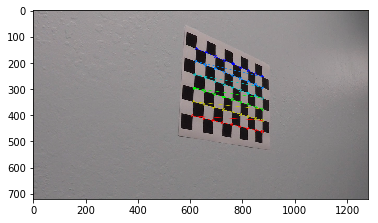

In [2]:
# prepare object points
nx = 9
ny = 6

# Make a list of calibration images
camera_cal = 'camera_cal'
camera_cal_images = os.listdir(camera_cal)

# Hard code the points based on https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html 
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
def get_objp(nx, ny):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    return objp

check_objp = get_objp(nx, ny)
print(check_objp.shape)

# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()\
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = np.copy(img)  # Delete this line
    undist = cv2.undistort(img, mtx, dist, None, None)
    return undist

objpoints= []
imgpoints= []

for fname in camera_cal_images:
    f = os.path.join(camera_cal, fname)
    print(f)
    img = cv2.imread(os.path.join(camera_cal, fname))
    print(img.shape)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners and append them to objpoints and imgpoints
    if ret == True:
        # Draw and display the corners
        # print(corners)
        objpoints.append(check_objp)
        imgpoints.append(corners)

        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

# Now we gathered all points calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


In [3]:

img = cv2.imread(os.path.join(camera_cal, 'calibration1.jpg'))
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

print(mtx)
print(newcameramtx)


[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128937e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[982.00366211   0.         679.60492147]
 [  0.         968.17901611 388.5261257 ]
 [  0.           0.           1.        ]]


In [4]:
# undistort and store
# todo(qingyouz): 
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite(os.path.join('output_images', 'calibresult.png'), dst)

True

In [8]:
# Apply distortion to raw images
raw_imgs = os.listdir('test_images/')
output_dir = 'output_images'


error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\core\src\array.cpp:3229: error: (-215:Assertion failed) cn <= 4 in function 'cv::scalarToRawData'


In [ ]:
# Use color transforms, gradients, etc., to create a thresholded binary image
# Edit this function to create your own pipeline.
def thresholded_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary


error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\core\src\array.cpp:3229: error: (-215:Assertion failed) cn <= 4 in function 'cv::scalarToRawData'


In [56]:
# Now with warped, detect lane lines
def find_lane_pixels(binary_warped, nwindows=9,margin=100,minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        # Left window, we should find the max and margin 100 / 50 
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current +  margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,
                      (win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),
                      (0,255,0)) 
        cv2.rectangle(out_img,
                      (win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),
                      (0,255,0)) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        left_idx = np.logical_and(np.logical_and(nonzero[0]>=win_y_low,nonzero[0]<win_y_high),np.logical_and(nonzero[1]>=win_xleft_low, nonzero[1]<win_xleft_high))
        good_left_inds = (nonzero[0][left_idx],nonzero[1][left_idx])
        good_left_inds = left_idx.nonzero()[0]
        right_idx = np.logical_and(np.logical_and(nonzero[0]>=win_y_low,nonzero[0]<win_y_high),np.logical_and(nonzero[1]<win_xright_high,nonzero[1]>=win_xright_low))
        good_right_inds = (nonzero[0][right_idx],nonzero[1][right_idx])
        good_right_inds = right_idx.nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = int(np.average(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.average(nonzerox[good_right_inds]))
        ### (`right` or `leftx_current`) on their mean position ###
        # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    # why left y and left x here?
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img




In [ ]:

# Apply a perspective transform to rectify binary image ("birds-eye view")
# https://classroom.udacity.com/nanodegrees/nd013/parts/edf28735-efc1-4b99-8fbb-ba9c432239c8/modules/5d1efbaa-27d0-4ad5-a67a-48729ccebd9c/lessons/78afdfc4-f0fa-4505-b890-5d8e6319e15c/concepts/d33ae3ea-01aa-414e-ad20-208dc161793d
# What is my src? The lane points detected?
# What is my dst? THe 4 corner poitns
# Just use a lane line with straight lines for now.
# Take src as four points on the lane in a picture
src = np.float32([[706,213],[448,596],[448,684],[706,1096]])
# Take dst as 
dst = np.float32([[720,200],[0,200],[0,1080],[720,1080]])

src = np.float32([[213,706],[596,448],[684,448],[1096,706]])
# Take dst as 
dst = np.float32([[200,719],[200,0],[1079,0],[1079,719]])
M = cv2.getPerspectiveTransform(src, dst)
# Qingyouz: Why do I need to put (x,y) here instead of (y,x)? 
# WHat's the fasted way to get to know where to use Y and where to use X?


error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\core\src\array.cpp:3229: error: (-215:Assertion failed) cn <= 4 in function 'cv::scalarToRawData'


In [57]:


def lane_finding_pipeline(img, img_name , mtx, dist, 
                          write_intermediate_images = True, 
                          write_color_binary=True, 
                          write_warped=True,
                          write_fit_polynomial=True):

    
    undistort = cv2.undistort(img, mtx, dist, None, None)
    if write_intermediate_images:
        undistort_name = img_name + '1_undistort' + '.jpg'
        undistort_path = os.path.join(output_dir, undistort_name)
        cv2.imwrite(undistort_path, undistort)
    
    color_binary = thresholded_pipeline(undistort)
    
    if write_color_binary:
        color_binary_name = img_name + '2_color_binary' + '.jpg'
        color_binary_path = os.path.join(output_dir, color_binary_name)
        cv2.imwrite(color_binary_path,color_binary)
    
    warped = cv2.warpPerspective(color_binary, M, (img.shape[1],img.shape[0]))

    if write_warped:
        warped_name = '{name}_{suffix}.{ext}'.format(name=img_name, suffix='3_warped', ext='jpg')
        warped_path = os.path.join(output_dir, warped_name)
        cv2.imwrite(warped_path,warped)
    
    warped_binary = np.zeros_like(warped[:,:,0])
    print(warped_binary.shape)
    warped_binary = np.maximum(np.maximum(warped[:,:,0],warped[:,:,1]),warped[:,:,2])
    
    
    # TODO
    fit_lane = fit_polynomial(warped_binary)
    if write_fit_polynomial:
        fit_poly_name = '{name}_{suffix}.{ext}'.format(name=img_name,suffix='4_fit_poly',ext='jpg')
        fit_poly_path = os.path.join(output_dir, fit_poly_name)
        cv2.imwrite(fit_poly_path, fit_lane)
    
    
    




(720, 1280)


(720, 1280)


(720, 1280)
(720, 1280)


(720, 1280)


(720, 1280)


(720, 1280)


(720, 1280)


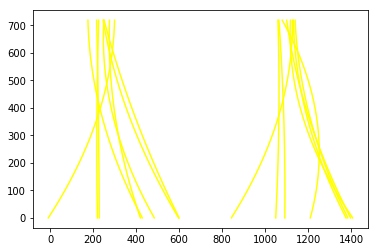

In [58]:

for f in raw_imgs:
    img = cv2.imread(os.path.join('test_images/', f))
    img_name = os.path.splitext(f)[0]
    end_result = lane_finding_pipeline(img, img_name, mtx, dist)
    

['output_images\\udstraight_lines1_color_binaries.jpg', 'output_images\\udstraight_lines2_color_binaries.jpg', 'output_images\\udtest1_color_binaries.jpg', 'output_images\\udtest2_color_binaries.jpg', 'output_images\\udtest3_color_binaries.jpg', 'output_images\\udtest4_color_binaries.jpg', 'output_images\\udtest5_color_binaries.jpg', 'output_images\\udtest6_color_binaries.jpg', 'output_images\\udstraight_lines1_color_binaries_warped.jpg', 'output_images\\udstraight_lines2_color_binaries_warped.jpg', 'output_images\\udtest1_color_binaries_warped.jpg', 'output_images\\udtest2_color_binaries_warped.jpg', 'output_images\\udtest3_color_binaries_warped.jpg', 'output_images\\udtest4_color_binaries_warped.jpg', 'output_images\\udtest5_color_binaries_warped.jpg', 'output_images\\udtest6_color_binaries_warped.jpg', 'output_images\\udstraight_lines1_color_binaries_warped_warped.jpg', 'output_images\\udstraight_lines2_color_binaries_warped_warped.jpg', 'output_images\\udtest1_color_binaries_warped

['output_images\\udstraight_lines1_color_binaries.jpg', 'output_images\\udstraight_lines2_color_binaries.jpg', 'output_images\\udtest1_color_binaries.jpg', 'output_images\\udtest2_color_binaries.jpg', 'output_images\\udtest3_color_binaries.jpg', 'output_images\\udtest4_color_binaries.jpg', 'output_images\\udtest5_color_binaries.jpg', 'output_images\\udtest6_color_binaries.jpg', 'output_images\\udstraight_lines1_color_binaries_warped.jpg', 'output_images\\udstraight_lines2_color_binaries_warped.jpg', 'output_images\\udtest1_color_binaries_warped.jpg', 'output_images\\udtest2_color_binaries_warped.jpg', 'output_images\\udtest3_color_binaries_warped.jpg', 'output_images\\udtest4_color_binaries_warped.jpg', 'output_images\\udtest5_color_binaries_warped.jpg', 'output_images\\udtest6_color_binaries_warped.jpg', 'output_images\\udstraight_lines1_color_binaries_warped_warped.jpg', 'output_images\\udstraight_lines2_color_binaries_warped_warped.jpg', 'output_images\\udtest1_color_binaries_warped

['output_images\\udstraight_lines1_color_binaries.jpg', 'output_images\\udstraight_lines2_color_binaries.jpg', 'output_images\\udtest1_color_binaries.jpg', 'output_images\\udtest2_color_binaries.jpg', 'output_images\\udtest3_color_binaries.jpg', 'output_images\\udtest4_color_binaries.jpg', 'output_images\\udtest5_color_binaries.jpg', 'output_images\\udtest6_color_binaries.jpg', 'output_images\\udstraight_lines1_color_binaries_warped.jpg', 'output_images\\udstraight_lines2_color_binaries_warped.jpg', 'output_images\\udtest1_color_binaries_warped.jpg', 'output_images\\udtest2_color_binaries_warped.jpg', 'output_images\\udtest3_color_binaries_warped.jpg', 'output_images\\udtest4_color_binaries_warped.jpg', 'output_images\\udtest5_color_binaries_warped.jpg', 'output_images\\udtest6_color_binaries_warped.jpg', 'output_images\\udstraight_lines1_color_binaries_warped_warped.jpg', 'output_images\\udstraight_lines2_color_binaries_warped_warped.jpg', 'output_images\\udtest1_color_binaries_warped